In [ ]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset as LFDataset
from scipy.sparse import coo_matrix

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_{users} = 943$ users, and  $n_{items}=1682$ movies.

In [136]:
# Download and unzip MovieLens 100k dataset
# !wget -nc https://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip -o ml-100k.zip


In [137]:
# import os
# import urllib.request
# import zipfile

# # URL and filename
# url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
# filename = "ml-100k.zip"
# extracted_folder = "ml-100k"

# # download the dataset if it does not exist
# urllib.request.urlretrieve(url, filename)

# # Extract the dataset
# with zipfile.ZipFile(filename, 'r') as zip_ref:
#     zip_ref.extractall(".")

- Matrix $Y$ (num_movies x num_users): ratings $y^{(i,j)}$ (from 1 to 5),
- Matrix $R$: binary where $R(i,j)=1$ if user $j$ gave a rating to movie $i$, and $R(i,j)=0$ otherwise.
- Matrix $X$: each row corresponds to the feature vector $x^{(i)}$ for the i-th movie.
- Matrix $\theta$: each row corresponds to one parameter vector $\theta^{(j)}$ for the j-th user.

In [138]:
n_users = 943
n_items = 1682 
n_features = 10

In [156]:
df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [157]:
Y = pd.pivot_table(df, values='rating', index='item_id', columns='user_id')
Y = Y.fillna(0).values  # Fill NaN with 0 for implicit feedback
R = (Y > 0).astype(int) # Create R matrix where 1 indicates a rating was given, 0 otherwise

In [144]:
def train_collaborative(X, W, B, Y, R, lr=0.001, epochs=100):
    losses = []

    for epoch in range(epochs):
        # Predictions (n_items x n_users)
        pred = X @ W.T + B  # B broadcasts over columns

        # Error only on observed ratings
        error = R * (pred - Y)  # shape: (n_items, n_users)

        # Compute loss
        loss = 0.5 * np.sum(error**2)
        losses.append(loss)        

        # Gradients
        dX = error @ W              # shape: (n_items, n_features)
        dW = error.T @ X            # shape: (n_users, n_features)
        dB = np.sum(error, axis=0)  # shape: (n_users,)

        # Update
        X -= lr * dX
        W -= lr * dW
        B -= lr * dB

     

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")

    return X, W, B, losses


In [145]:
np.random.seed(42)
X = np.random.randn(n_items, n_features)
W = np.random.randn(n_users, n_features)
B = np.random.randn(n_users)

X_learned, W_learned, B_learned, losses = train_cf_updated(X, W, B, Y, R, lr=0.001, epochs=100)


Epoch 0: Loss = 1258033.9880
Epoch 10: Loss = 133534.8823
Epoch 20: Loss = 71201.6704
Epoch 30: Loss = 53943.3298
Epoch 40: Loss = 47115.9595
Epoch 50: Loss = 43662.9532
Epoch 60: Loss = 41545.9129
Epoch 70: Loss = 40070.2397
Epoch 80: Loss = 38954.3033
Epoch 90: Loss = 38064.0237
Epoch 99: Loss = 37395.1728


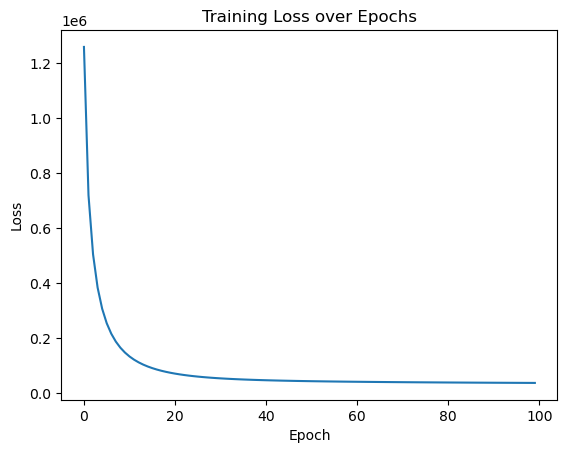

In [146]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [154]:
df_item = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None)
df_item.columns = [
    'item_id', 'movie title', 'release date', 'video release date',
    'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
    "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
    'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
    'Thriller', 'War', 'Western'
]
df_item.head()

,item_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [164]:
Y = pd.DataFrame(Y)
Y.columns = Y.columns+1  # Set user IDs as columns
Y.index = df_item['movie title']  # Set movie titles as index
Y

,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
GoldenEye (1995),3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
Four Rooms (1995),4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Get Shorty (1995),3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
Copycat (1995),3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mat' i syn (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B. Monkey (1998),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sliding Doors (1998),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Map IDs to LightFM's dataset
lfm_dataset = LFDataset()
lfm_dataset.fit(df['user_id'], df['item_id'])

(interactions, _) = lfm_dataset.build_interactions([(row['user_id'], row['item_id']) for _, row in df[df['interaction'] == 1].iterrows()])

# Train model using implicit feedback
model = LightFM(no_components=10, loss='warp')  # WARP for implicit
model.fit(interactions, epochs=10, num_threads=2)